In [55]:
import matplotlib.pyplot as plt
import os

import matplotlib.image as mpimg
import random
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from datasets_utils import *
if not os.path.exists('./causal_data/pendulum/'):
    os.makedirs('./causal_data/pendulum/train/')
    os.makedirs('./causal_data/pendulum/test/')

In [57]:
def projection(theta, phi, x, y, base = -0.5):
    b = y - x * math.tan(phi)
    shade = (base - b) / math.tan(phi)
    return shade

In [58]:
# i = np.random.randint(-60, 60)
# j = np.random.randint(50, 150)
# [0, 10] shade
# [1, 18] mid

In [59]:
scale = np.array([[0,44],[100,40],[7,7.5],[10,10]])
count = 0
empty = pd.DataFrame(columns=['i', 'j', 'shade','mid'])
true_df = pd.DataFrame(columns=['i', 'j', 'shade','mid'])
for i in tqdm(range(-60, 60)): #pendulum
    for j in range(50, 150): #light
        if j == 100:
            continue
        plt.rcParams['figure.figsize'] = (1.0, 1.0)
        theta = i*math.pi/200.0
        phi = j*math.pi/200.0
        x = 10 + 8*math.sin(theta)
        y = 10.5 - 8*math.cos(theta)

        ball = plt.Circle((x,y), 1.5, color = 'firebrick')
        gun = plt.Polygon(([10,10.5],[x,y]), color = 'black', linewidth = 3)

        light = projection(theta, phi, 10, 10.5, 20.5)
        sun = plt.Circle((light,20.5), 3, color = 'orange')

        #calculate the mid index of
        ball_x = 10+9.5*math.sin(theta)
        ball_y = 10.5-9.5*math. cos(theta)
        mid = (projection(theta, phi, 10.0, 10.5)+projection(theta, phi, ball_x, ball_y))/2
        shade = max(3,abs(projection(theta, phi, 10.0, 10.5)-projection(theta, phi, ball_x, ball_y)))

        shadow = plt.Polygon(([mid - shade/2.0, -0.5],[mid + shade/2.0, -0.5]), color = 'black', linewidth = 3)

        ax = plt.gca()
        ax.add_artist(gun)
        ax.add_artist(ball)
        ax.add_artist(sun)
        ax.add_artist(shadow)
        ax.set_xlim((0, 20))
        ax.set_ylim((-1, 21))
        new=pd.DataFrame({
                  'i':(i-scale[0][0])/(scale[0][1]-0),
                  'j':(j-scale[1][0])/(scale[1][1]-0),
                  'shade':(shade-scale[2][0])/(scale[2][1]-0),
                  'mid':(mid-scale[2][0])/(scale[2][1]-0)
                  }, index=[1])
        empty = pd.concat([empty, new], ignore_index=True)
        new=pd.DataFrame({
                  'i':i,
                  'j':j,
                  'shade':shade,
                  'mid':mid
                  }, index=[1])
        true_df = pd.concat([true_df, new], ignore_index=True)
        
        plt.axis('off')
        if count == 7:
            plt.savefig('./causal_data/pendulum/test/a_' + str(int(i)) + '_' + str(int(j)) + '_' + str(int(shade)) + '_' + str(int(mid)) +'.png',dpi=96)
            count = 0
        else:
            plt.savefig('./causal_data/pendulum/train/a_' + str(int(i)) + '_' + str(int(j)) + '_' + str(int(shade)) + '_' + str(int(mid)) +'.png',dpi=96)
        plt.clf()
        count += 1

100%|█████████████████████████████████████████| 120/120 [02:38<00:00,  1.32s/it]


<Figure size 100x100 with 0 Axes>

In [90]:
len(os.listdir('causal_data/pendulum/train')), len(os.listdir('causal_data/pendulum/test'))

(10183, 1697)

In [61]:
class Synthetic(data.Dataset):
    def __init__(self, root, dataset="train"):
        root = root + "/" + dataset

        imgs = os.listdir(root)

        self.dataset = dataset

        self.imgs = [os.path.join(root, k) for k in imgs]
        self.imglabel = [list(map(int, k[:-4].split("_")[1:])) for k in imgs]
        self.transforms = transforms.Compose([transforms.ToTensor()])

    def __getitem__(self, idx):
        img_path = self.imgs[idx]

        label = torch.from_numpy(np.asarray(self.imglabel[idx]))
        pil_img = Image.open(img_path)
        label = torch.from_numpy(np.asarray(label))
        if self.transforms:
            data = self.transforms(pil_img)[:3]
        else:
            pil_img = np.asarray(pil_img)[:, :, :3].reshape(96, 96, 3)
            data = torch.from_numpy(pil_img)
        return data, label.float()

    def __len__(self):
        return len(self.imgs)

In [62]:
def get_synthetic_data(dataset_dir, batch_size):
	train_dataset = Synthetic(dataset_dir, "train")
	test_dataset = Synthetic(dataset_dir, "test")
	train_loader = Data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
	test_loader = Data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
	return train_dataset, test_dataset, train_loader, test_loader

In [63]:
d = get_synthetic_data('causal_data/pendulum', 256)
train_dataset, test_dataset, train_loader, test_loader = d

In [64]:
train_dataset[0][0].shape

torch.Size([3, 96, 96])

COUNTERFACTUAL

In [76]:
!rm -r ./causal_data/pendulum/cf

In [77]:
if not os.path.exists('./causal_data/pendulum/cf'):
    os.makedirs('./causal_data/pendulum/cf')

In [78]:
def projection(theta, phi, x, y, base=-0.5):
    b = y - x * np.tan(phi)
    shade = (base - b) / np.tan(phi)
    return shade

# Input arrays
def generate(i, j, shadow_len=None, shadow_pos=None):
    X = np.zeros((i.shape[0], 3, 96, 96))
    scale = np.array([[0, 44], [100, 40], [7, 7.5], [10, 10]])
    count = 0
    plt.rcParams['figure.figsize'] = (1.0, 1.0)
    theta = i * math.pi / 200.0
    phi = j * math.pi / 200.0
        
    x = 10 + 8 * np.sin(theta)
    y = 10.5 - 8 * np.cos(theta)

    # calculate the mid index of
    ball_x = 10 + 9.5 * np.sin(theta)
    ball_y = 10.5 - 9.5 * np.cos(theta)

    if shadow_pos != None:
        mid = np.ones(i.shape[0]) * shadow_pos
    else:
        mid = (projection(theta, phi, 10.0, 10.5) + projection(theta, phi, ball_x, ball_y)) / 2

    if shadow_len != None:
        shade = np.ones(i.shape[0]) * shadow_len
    else:
        shade = np.maximum(3, np.abs(projection(theta, phi, 10.0, 10.5) - projection(theta, phi, ball_x, ball_y)))

    for e in range(i.shape[0]):
        ball = plt.Circle((x[e], y[e]), 1.5, color='firebrick')
        gun = plt.Polygon(([10, 10.5], [x[e], y[e]]), color='black', linewidth=3)

        light = projection(theta[e], phi[e], 10, 10.5, 20.5)
        sun = plt.Circle((light, 20.5), 3, color='orange')

        shadow = plt.Polygon(([mid[e] - shade[e] / 2.0, -0.5], [mid[e] + shade[e] / 2.0, -0.5]), color='black',
                             linewidth=3)

        ax = plt.gca()
        ax.add_artist(gun)
        ax.add_artist(ball)
        ax.add_artist(sun)
        ax.add_artist(shadow)
        ax.set_xlim((0, 20))
        ax.set_ylim((-1, 21))

        new = pd.DataFrame({
            'i': (i[e] - scale[0][0]) / (scale[0][1] - 0),
            'j': (j[e] - scale[1][0]) / (scale[1][1] - 0),
            'shade': (shade[e] - scale[2][0]) / (scale[2][1] - 0),
            'mid': (mid[e] - scale[2][0]) / (scale[2][1] - 0)
        },
            index=[1])
        plt.axis('off')

        plt.savefig(
            './causal_data/pendulum/cf/a_' + str(int(i[e])) + '_' + str(int(j[e])) + '_' + str(int(shade[e])) + '_' + str(
                int(mid[e])) + '.png', dpi=96)

        pil_img = Image.open('./causal_data/pendulum/cf/a_' + str(int(i[e])) + '_' + str(int(j[e])) + '_' + str(int(shade[e])) + '_' + str(
                int(mid[e])) + '.png')
        pil_img = np.asarray(pil_img)
        transform = transforms.Compose([transforms.ToTensor()])
        pil_img = transform(pil_img)
        X[e] = pil_img[:3]

        plt.clf()
        count += 1
    return X, np.array([i, j, shade, mid]).T

In [116]:
true_df['shade'].min(), true_df['shade'].max() 

(3, 13.435028842544401)

In [117]:
true_df['mid'].min(), true_df['mid'].max() 

(-2.050850774891753, 21.69446725125492)

In [79]:
def scale(vector, name):
    mi = true_df[name].min()
    ma = true_df[name].max()
    return vector * (ma - mi) + mi

In [80]:
# VISUALIZE ANY COMBINATION
# x, l = generate(np.array([-60]), np.array([150]), 13, 21)
# print(l)
# plt.imshow(x[0].transpose(1,2,0))

In [81]:
cf_ds_size = 1697
while len(os.listdir('./causal_data/pendulum/cf')) != cf_ds_size:
    i = np.random.randint(-60, 60)
    j = np.random.randint(50, 150)
    while j == 100 or j == 0:
        j = np.random.randint(50, 150)
    shade = scale(np.random.rand(), 'shade')
    mid = scale(np.random.rand(), 'mid')
    _ = generate(np.array([i]), np.array([j]), shade, mid)

<Figure size 100x100 with 0 Axes>

In [82]:
cf_dataset = Synthetic('causal_data/pendulum', "cf")
cf_loader = Data.DataLoader(cf_dataset, batch_size=256, shuffle=False)

In [84]:
len(cf_dataset)

1697

tensor([48., 98.,  4.,  9.])


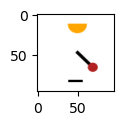

tensor([49., 62., 10.,  0.])


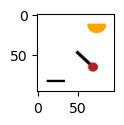

tensor([ 46., 118.,  12.,  18.])


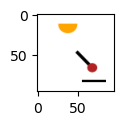

In [85]:
X, labels = next(iter(cf_loader))
for i, (x, l) in enumerate(zip(X, labels)):
    if i >= 3:
        break
    print(l)
    plt.imshow(x.permute(1,2,0))
    plt.show()

In [114]:
!zip -q -r pendulum.zip pendulum

In [87]:
!mkdir causal_data/pendulum/regressor_data

In [91]:
def projection(theta, phi, x, y, base=-0.5):
    b = y - x * np.tan(phi)
    shade = (base - b) / np.tan(phi)
    return shade

# Input arrays
def generate(i, j, shadow_len=None, shadow_pos=None):
    X = np.zeros((i.shape[0], 3, 96, 96))
    scale = np.array([[0, 44], [100, 40], [7, 7.5], [10, 10]])
    count = 0
    plt.rcParams['figure.figsize'] = (1.0, 1.0)
    theta = i * math.pi / 200.0
    phi = j * math.pi / 200.0
        
    x = 10 + 8 * np.sin(theta)
    y = 10.5 - 8 * np.cos(theta)

    # calculate the mid index of
    ball_x = 10 + 9.5 * np.sin(theta)
    ball_y = 10.5 - 9.5 * np.cos(theta)

    if shadow_pos != None:
        mid = np.ones(i.shape[0]) * shadow_pos
    else:
        mid = (projection(theta, phi, 10.0, 10.5) + projection(theta, phi, ball_x, ball_y)) / 2

    if shadow_len != None:
        shade = np.ones(i.shape[0]) * shadow_len
    else:
        shade = np.maximum(3, np.abs(projection(theta, phi, 10.0, 10.5) - projection(theta, phi, ball_x, ball_y)))

    for e in range(i.shape[0]):
        ball = plt.Circle((x[e], y[e]), 1.5, color='firebrick')
        gun = plt.Polygon(([10, 10.5], [x[e], y[e]]), color='black', linewidth=3)

        light = projection(theta[e], phi[e], 10, 10.5, 20.5)
        sun = plt.Circle((light, 20.5), 3, color='orange')

        shadow = plt.Polygon(([mid[e] - shade[e] / 2.0, -0.5], [mid[e] + shade[e] / 2.0, -0.5]), color='black',
                             linewidth=3)

        ax = plt.gca()
        ax.add_artist(gun)
        ax.add_artist(ball)
        ax.add_artist(sun)
        ax.add_artist(shadow)
        ax.set_xlim((0, 20))
        ax.set_ylim((-1, 21))

        new = pd.DataFrame({
            'i': (i[e] - scale[0][0]) / (scale[0][1] - 0),
            'j': (j[e] - scale[1][0]) / (scale[1][1] - 0),
            'shade': (shade[e] - scale[2][0]) / (scale[2][1] - 0),
            'mid': (mid[e] - scale[2][0]) / (scale[2][1] - 0)
        },
            index=[1])
        plt.axis('off')

        plt.savefig(
            './causal_data/pendulum/regressor_data/a_' + str(int(i[e])) + '_' + str(int(j[e])) + '_' + str(int(shade[e])) + '_' + str(
                int(mid[e])) + '.png', dpi=96)

        pil_img = Image.open('./causal_data/pendulum/regressor_data/a_' + str(int(i[e])) + '_' + str(int(j[e])) + '_' + str(int(shade[e])) + '_' + str(
                int(mid[e])) + '.png')
        pil_img = np.asarray(pil_img)
        transform = transforms.Compose([transforms.ToTensor()])
        pil_img = transform(pil_img)
        X[e] = pil_img[:3]

        plt.clf()
        count += 1
    return X, np.array([i, j, shade, mid]).T

In [92]:
ds_size = 100000
while len(os.listdir('./causal_data/pendulum/regressor_data')) != ds_size:
    i = np.random.randint(-60, 60)
    j = np.random.randint(50, 150)
    while j == 100 or j == 0:
        j = np.random.randint(50, 150)
    shade = scale(np.random.rand(), 'shade')
    mid = scale(np.random.rand(), 'mid')
    _ = generate(np.array([i]), np.array([j]), shade, mid)
    if len(os.listdir('./causal_data/pendulum/regressor_data')) % 1000 == 0:
        print(len(os.listdir('./causal_data/pendulum/regressor_data')))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000


<Figure size 100x100 with 0 Axes>

In [98]:
!ls causal_data/pendulum/regressor_data

cf             regressor_data test           train


In [99]:
import os
import shutil
import random
# Define paths
base_dir = 'causal_data/pendulum/regressor_data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
# Create train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
# Get list of all image files in the base directory
all_files = [f for f in os.listdir(base_dir) if os.path.isfile(os.path.join(base_dir, f))]
# Shuffle the list of files
random.shuffle(all_files)
# Split the files into train and test sets
split_index = int(0.8 * len(all_files))
train_files = all_files[:split_index]
test_files = all_files[split_index:]
# Move files to train and test directories
for f in train_files:
    shutil.move(os.path.join(base_dir, f), os.path.join(train_dir, f))
for f in test_files:
    shutil.move(os.path.join(base_dir, f), os.path.join(test_dir, f))
print(f"Moved {len(train_files)} files to {train_dir}")
print(f"Moved {len(test_files)} files to {test_dir}")

Moved 80000 files to causal_data/pendulum/regressor_data/train
Moved 20000 files to causal_data/pendulum/regressor_data/test


In [101]:
!ls

CVAE_pendulum_zdim=3.ipynb datasets_utils.py
Pendulum.ipynb             pendulum.zip
__pycache__                regressor_data.zip
causal_data


In [100]:
!zip -q -r regressor_data.zip causal_data/pendulum/regressor_data

In [108]:
%cd pendulum

/Users/leedatroeshestova/Thesis/Experiments/data/pendulum/causal_data/pendulum


In [109]:
!ls

cf             regressor_data test           train


In [110]:
!zip -q -r regressor_data.zip regressor_data